# 猫狗数据迁移学习

In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import glob
import os

tf.__version__

'2.0.0'

## 准备数据集

### 准备训练集

In [2]:
# 数据集目录
image_dir = "dataset\\dog_and_cat"
# 训练集路径
train_path = os.path.join(image_dir, "train")
# 数据集路径
train_image_path = glob.glob(train_path + "\\*\\*")
train_num = len(train_image_path)
# 训练集标签 cat:1, dog:0
train_label = [int(path.split('\\')[-2]=='cat') for path in train_image_path]
# 创建数据集
train_dataset = tf.data.Dataset.from_tensor_slices((train_image_path, train_label))

In [3]:
# 数据处理
def data_preprocess(path, label):
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, (150, 150))
    # 归一化
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    label = tf.reshape(label, [1])
    return (image, label)

#If num_parallel_calls=`tf.data.experimental.AUTOTUNE`, then the number of parallel calls is set dynamically based on available CPU.
train_dataset = train_dataset.map(data_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset

<ParallelMapDataset shapes: ((150, 150, 3), (1,)), types: (tf.float32, tf.int32)>

cat


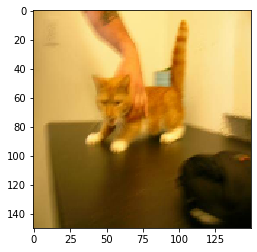

In [4]:
# 打印第一张图片
for image, label in train_dataset.take(1):
    plt.imshow(image.numpy())
    print('cat' if label.numpy()[0] == 1 else 'dog')

In [5]:
# 数据集处理
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(train_num).repeat().batch(BATCH_SIZE)
# 训练时预取一个batch的数据
train_dataset = train_dataset.prefetch(1)
train_dataset

<PrefetchDataset shapes: ((None, 150, 150, 3), (None, 1)), types: (tf.float32, tf.int32)>

### 准备测试集

In [6]:
# 测试集路径
test_path = os.path.join(image_dir, "test")
# 数据集路径
test_image_path = glob.glob(test_path + "\\*\\*")
test_num = len(test_image_path)
# 标签 cat:1, dog:0
test_label = [int(path.split('\\')[-2]=='cat') for path in test_image_path]
# 创建数据集
test_dataset = tf.data.Dataset.from_tensor_slices((test_image_path, test_label))
#If num_parallel_calls=`tf.data.experimental.AUTOTUNE`, then the number of parallel calls is set dynamically based on available CPU.
test_dataset = test_dataset.map(data_preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
# 数据集处理
test_dataset = test_dataset.batch(BATCH_SIZE)
# 测试时预取一个batch的数据
test_dataset = test_dataset.prefetch(1)
test_dataset

<PrefetchDataset shapes: ((None, 150, 150, 3), (None, 1)), types: (tf.float32, tf.int32)>

## 构建模型

### 使用VGG16预训练模型， 截取中间层

In [7]:
# VGG16的16指有16层的参数需要训练
# weights='imagenet'代表加载在imagenet上的预训练权重
# include_top=False代表不加载后面的全连接层
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
base_model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [8]:
# 冻结卷积层权重
base_model.trainable=False

In [9]:
# 取block5_conv3层的输出
last_layer = base_model.get_layer("block5_conv3")
last_output = last_layer.output

In [10]:
# 构建新的网络
x = tf.keras.layers.GlobalAveragePooling2D()(last_output)
x = tf.keras.layers.Dense(256, activation='relu')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
VGG_model = tf.keras.Model(base_model.input, x)
VGG_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [11]:
VGG_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.005), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

In [12]:
VGG_model.fit(train_dataset,
              epochs = 10,
              steps_per_epoch = train_num // BATCH_SIZE,
              validation_data = test_dataset,
              validation_steps = test_num // BATCH_SIZE)

Train for 62 steps, validate for 31 steps
Epoch 1/10
62/62 [==============================] - 20s 322ms/step - loss: 0.4520 - accuracy: 0.7707 - val_loss: 0.2877 - val_accuracy: 0.8871
Epoch 2/10
62/62 [==============================] - 14s 232ms/step - loss: 0.2871 - accuracy: 0.8846 - val_loss: 0.2520 - val_accuracy: 0.8972
Epoch 3/10
62/62 [==============================] - 15s 249ms/step - loss: 0.2467 - accuracy: 0.8957 - val_loss: 0.3446 - val_accuracy: 0.8448
Epoch 4/10
62/62 [==============================] - 15s 248ms/step - loss: 0.2558 - accuracy: 0.8931 - val_loss: 0.2554 - val_accuracy: 0.8942
Epoch 5/10
62/62 [==============================] - 15s 248ms/step - loss: 0.2189 - accuracy: 0.9113 - val_loss: 0.2508 - val_accuracy: 0.8972
Epoch 6/10
62/62 [==============================] - 15s 249ms/step - loss: 0.2086 - accuracy: 0.9153 - val_loss: 0.2652 - val_accuracy: 0.8901
Epoch 7/10
62/62 [==============================] - 15s 248ms/step - loss: 0.1806 - accuracy: 0.9259

### 微调
微调是在之前冻结了卷积层，训练后面全连接层结束后，解冻靠后的几个卷积层再训练

In [13]:
len(VGG_model.layers)

21

In [14]:
for layer in VGG_model.layers:
    print(layer)

In [15]:
VGG_model.trainable = True
# 解冻靠后的两个卷积层
fine_tune = -5
for layer in VGG_model.layers[:fine_tune]:
    layer.trainable = False
# 重新编译模型
VGG_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

VGG_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [16]:
# 已经训练了10个epoch
initial_epoch = 10
VGG_model.fit(train_dataset,
              epochs = initial_epoch + 10,
              initial_epoch = initial_epoch,
              steps_per_epoch = train_num // BATCH_SIZE,
              validation_data = test_dataset,
              validation_steps = test_num // BATCH_SIZE)

Train for 62 steps, validate for 31 steps
Epoch 11/20
62/62 [==============================] - 19s 299ms/step - loss: 2.8504 - accuracy: 0.6552 - val_loss: 0.3200 - val_accuracy: 0.8558
Epoch 12/20
62/62 [==============================] - 16s 253ms/step - loss: 0.3159 - accuracy: 0.8599 - val_loss: 0.2682 - val_accuracy: 0.8881
Epoch 13/20
62/62 [==============================] - 17s 267ms/step - loss: 0.2396 - accuracy: 0.9068 - val_loss: 0.2679 - val_accuracy: 0.8921
Epoch 14/20
62/62 [==============================] - 17s 268ms/step - loss: 0.2371 - accuracy: 0.9037 - val_loss: 0.2068 - val_accuracy: 0.9143
Epoch 15/20
62/62 [==============================] - 17s 267ms/step - loss: 0.1921 - accuracy: 0.9264 - val_loss: 0.3939 - val_accuracy: 0.8216
Epoch 16/20
62/62 [==============================] - 17s 267ms/step - loss: 0.1896 - accuracy: 0.9204 - val_loss: 0.2095 - val_accuracy: 0.9204ac - ETA: 0s - loss: 0.1935 - accuracy: 
Epoch 17/20
62/62 [==============================] - 1

### 使用Xception预训练模型，使用全部卷积层

In [17]:
# Xception模型的高宽不能小于71
# pooling='avg'代表包含最后的全局平均池化
base_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, pooling='avg', input_shape=(150, 150, 3))
base_model.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 74, 74, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 74, 74, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 74, 74, 32)   0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [18]:
base_model.trainable = False

In [19]:
Xception_model = tf.keras.Sequential()
Xception_model.add(base_model)
Xception_model.add(tf.keras.layers.Dense(256, activation='relu'))
Xception_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
Xception_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 21,386,281
Trainable params: 524,801
Non-trainable params: 20,861,480
_________________________________________________________________


In [20]:
Xception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.002), 
                       loss='binary_crossentropy', 
                       metrics=['accuracy'])

In [21]:
Xception_model.fit(train_dataset,
                   epochs = 10,
                   steps_per_epoch = train_num // BATCH_SIZE,
                   validation_data = test_dataset,
                   validation_steps = test_num // BATCH_SIZE)

Train for 62 steps, validate for 31 steps
Epoch 1/10
62/62 [==============================] - 17s 281ms/step - loss: 0.4078 - accuracy: 0.7939 - val_loss: 0.1046 - val_accuracy: 0.9647
Epoch 2/10
62/62 [==============================] - 12s 198ms/step - loss: 0.2918 - accuracy: 0.8710 - val_loss: 0.1299 - val_accuracy: 0.9577
Epoch 3/10
62/62 [==============================] - 14s 233ms/step - loss: 0.2332 - accuracy: 0.8987 - val_loss: 0.1485 - val_accuracy: 0.9486
Epoch 4/10
62/62 [==============================] - 14s 232ms/step - loss: 0.2383 - accuracy: 0.9037 - val_loss: 0.1501 - val_accuracy: 0.9496
Epoch 5/10
62/62 [==============================] - 14s 231ms/step - loss: 0.1704 - accuracy: 0.9239 - val_loss: 0.5648 - val_accuracy: 0.8952
Epoch 6/10
62/62 [==============================] - 13s 215ms/step - loss: 0.1657 - accuracy: 0.9370 - val_loss: 0.1717 - val_accuracy: 0.9536
Epoch 7/10
62/62 [==============================] - 13s 212ms/step - loss: 0.1809 - accuracy: 0.9183

### 微调

In [22]:
len(base_model.layers)

133

In [23]:
for layer in base_model.layers:
    print(layer)

In [24]:
base_model.trainable = True
# 解冻靠后的两个卷积层
fine_tune = -7
for layer in base_model.layers[:fine_tune]:
    layer.trainable = False
# 重新编译模型
Xception_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
                       loss='binary_crossentropy', 
                       metrics=['accuracy'])
Xception_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense_2 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 21,386,281
Trainable params: 5,273,601
Non-trainable params: 16,112,680
_________________________________________________________________


In [25]:
# 已经训练了10个epoch
initial_epoch = 10
Xception_model.fit(train_dataset,
                   epochs = initial_epoch + 10,
                   initial_epoch = initial_epoch,
                   steps_per_epoch = train_num // BATCH_SIZE,
                   validation_data = test_dataset,
                   validation_steps = test_num // BATCH_SIZE)

Train for 62 steps, validate for 31 steps
Epoch 11/20
62/62 [==============================] - 19s 314ms/step - loss: 0.3268 - accuracy: 0.8886 - val_loss: 0.2254 - val_accuracy: 0.9567
Epoch 12/20
62/62 [==============================] - 13s 216ms/step - loss: 0.1037 - accuracy: 0.9617 - val_loss: 0.2778 - val_accuracy: 0.9567
Epoch 13/20
62/62 [==============================] - 16s 250ms/step - loss: 0.0545 - accuracy: 0.9834 - val_loss: 0.4075 - val_accuracy: 0.9536
Epoch 14/20
62/62 [==============================] - 16s 252ms/step - loss: 0.0372 - accuracy: 0.9899 - val_loss: 1.8457 - val_accuracy: 0.8931
Epoch 15/20
62/62 [==============================] - 15s 248ms/step - loss: 0.0586 - accuracy: 0.9819 - val_loss: 0.2314 - val_accuracy: 0.9587
Epoch 16/20
62/62 [==============================] - 15s 243ms/step - loss: 0.0323 - accuracy: 0.9859 - val_loss: 0.2458 - val_accuracy: 0.9587
Epoch 17/20
62/62 [==============================] - 16s 252ms/step - loss: 0.0190 - accuracy: